In [36]:
# import exportnb
# exportnb.export_notebooks(['./210618 - Functions_for_import.ipynb'])
import setup

In [37]:
import importlib
importlib.reload(setup)

<module 'setup' from '/home/guillermo/Nextcloud/projects/Distributed_Q_gates_clean/Codes/setup.py'>

In [38]:
import numpy as np
import os.path
from numpy import pi, floor, sqrt
import scipy.sparse as sp
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from joblib import delayed, Parallel, parallel_backend

In [39]:
styles = ['science']
prefix = '../stylelib/'
sufix = '.mplstyle'
for i in range(len(styles)):
    styles[i] = prefix + styles[i] + sufix
plt.style.use(styles)
plt.rcParams.update({'font.size': 20})

## Function that implements evolution

In [40]:
from numpy import pi as π

def Trotter_solver_dynamics(time,v0,control,g1=None,g2=None):
    vt = [v0]
    last_t = time[0]
    for t in time[1:]:
        dt = t - last_t
        v0 = scipy.sparse.linalg.expm_multiply((-1j*dt) * control.Hamiltonian(g1=g1(t), g2=g2(t)), v0)
        vt.append(v0)
        last_t = t
    return np.array(vt).T

## Shape of the controls

In [41]:
def sech(x):
    return 1/np.cosh(x)

def sech(x):
    return np.tanh(x)/np.sinh(x)
    
def gt(t, σ, κ):
    if σ == 0.5*κ:
        return σ / np.cosh(σ*t)
    th = np.tanh(t*σ)
    ex = np.exp(-2*t*σ)
    return (κ - 2*σ*th)/np.sqrt(2*(κ*(1+ex)-2*σ)/σ)

## State transfer

We define a state transfer protocol with two pulses centered at $\pm t_{delay}=\pm t_{prop}/2.$ Each pulse lasts $24/\kappa$ so that the sech profile is properly dampened at the beginning and at the end. We only need $\sim 3000$ time steps, because the number of time steps is determined by how fast the Hamiltonian changes --- we can do arbitrarily large exponentials, Python takes care of that; our only error is the fact that we do piecewise constant Hamiltonian simulations.

In [42]:
import scipy.interpolate

def state_transfer(lamb_shift=None, δ1=2*π*8.40701933547913, δ2=2*π*8.40701933547913,
                   ω1=2*π*8.40701933547913, ω2=2*π*8.40701933547913,
                    kappa=2*π*20e-3, κ1=None, κ2=None, σ=0.5,
                   Tfp=10, Nt=3000, lwv=30, Nm=2101,
                   quiet=False, filename=None):
    if κ1 is None:
        κ1 = kappa
    if κ2 is None:
        κ2 = κ1
    if lamb_shift is None:
        lamb_shift = interp_lamb(κ1, lwv)
        
  
    
    control = setup.Exp2QB2Cavities(δLamb = lamb_shift, δ1 = δ1, δ2 = δ2, ω1 = ω1, ω2 = ω2, g1=0, g2=0, κ1=κ1, κ2=κ2, l=lwv, mmax=Nm)
    
    ## solve dynamics
    tdelay = 1*control.tprop #separation between protocol g_1(t) and g_2(t) /time reversed. 
    σ *= κ1
    duration = tdelay + 2 * (Tfp/σ)
    time = np.linspace(-duration/2, duration/2, Nt)
   
    def g1t(t):
        return gt(t + tdelay/2, σ,  κ1)

    def g2t(t):
        return gt(tdelay/2 - t, σ,  κ2)

    #Control initial/final values:
    print(f'Initial value of the control g_1(-tf)= (2π)*{g1t(time[0])/2/π*1e3}MHz')
    print('κ1= (2π)',κ1/2/π*1e3,'MHz')    
    print(f'Total time ={duration/control.tprop}*Propagation_time')

    vt = Trotter_solver_dynamics(time, control.qubit_excited(which=0), control, g1=g1t, g2=g2t)
    P = np.abs(vt)**2
    ## Showing results:
    Pwaveguide = np.sum(P[4:,:],0)
    print(f'|q_1(tf)|^2 = {P[0,-1]}\n'
          f'|c_1(tf)|^2 = {P[2,-1]}\n'
          f'|wv(tf)|^2  = {Pwaveguide[-1]} (max = {max(Pwaveguide)})\n'
          f'|c_2(tf)|^2 = {P[3,-1]}\n'
          f'|q_2(tf)|^2 = {P[1,-1]}\n'
          f' 1-F        = {1-P[1,-1]}')
    if not quiet:
        fig, (ax, axc) = plt.subplots(nrows=2, figsize=(8,6), sharex=True)
        ax.plot(time*κ1, P[0,:], label='qubit 1')
        ax.plot(time*κ1, P[1,:], label='qubit 2')
        ax.plot(time*κ1, P[2,:], '--', label='cavity 1')
        ax.plot(time*κ1, P[3,:], '--', label='cavity 2')
        ax.plot(time*κ1, Pwaveguide, '-.', label='waveguide')
        #ax.set_xlabel(r'$t\κ1$')
        ax.legend(fontsize=16)
        ax.set_title(f'$l={lwv}\,m,\,'
                     r'\omega=2\pi\times'
                     f'{control.ω1/(2*π)}'
                     r'\,\mathrm{GHz},\,\kappa_1=2\pi\times'
                     f'{np.round(κ1/(2e-3*π))}'
                     r'\,\mathrm{MHz},\,\sigma/\kappa_1='
                     f'{np.round(σ/κ1,3)}$', fontsize=16)
        axc.plot(time*κ1, g1t(time)/κ1, label=r'$g_1(t)/\kappa_1$')
        axc.plot(time*κ1, g2t(time)/κ2, label=r'$g_2(t)/\kappa_2$')
        axc.set_xlabel(r'$t\kappa_1$')
        axc.set_ylabel(r'$g_i(t)/\kappa_i$')
        axc.legend(fontsize=16)
        fig.tight_layout()
        plt.show()
        if filename:
            fig.savefig(filename)
    
    timeres = time/control.tprop
    q1end = P[0,-1]
    q2end = P[1,-1]
    return q2end, q1end, control.ωrelevant

The state transfer protocol also works in a limit in which the photons do not fit into the waveguide:

With our new controls can vary the width of the pulse, so that it is no longer $\kappa/2$, and still get good transfer

## Systematic studies

We explore three lengths, $l=30$m, $l=5$m and $l=1$m, for a variety of $\kappa$, and also in one instance for pulses with enlarged duration $\sigma=\kappa/4.$ We also explore different values of $\eta$ and detunings with respect to one of the WG modes. Unless otherwise specified. $\eta = 1$, and resonant condition.

In [18]:
# Execute this line to remove the precomputed files
# !del state_transfer_*.npy

In [11]:
all_kappas = 2*π*np.logspace(0.0, 2.0, 36)*1e-3

In [12]:
# 1meter. 

if os.path.exists('../Data/P_transfer_1m_71modes.npy'):
    P_transfer_1m_71modes = np.load('../Data/P_transfer_1m_71modes.npy', allow_pickle = True)
    
else:  
    with parallel_backend('loky', n_jobs=36):
        P_transfer_1m_71modes = Parallel()(delayed(state_transfer)(δ1=2*π*8.492099722936853, δ2=2*π*8.492099722936853,
                   ω1=2*π*8.492099722936853, ω2=2*π*8.492099722936853, lamb_shift=-0.01732777777777778*κ, kappa=κ, Tfp=15, lwv=1, Nm=71, quiet=True)
                     for κ in all_kappas)
        P_transfer_1m_71modes = np.array(P_transfer_1m_71modes, dtype = object)
    np.save('../Data/P_transfer_1m_71modes.npy', P_transfer_1m_71modes)

In [13]:
# 5meters. Off-resonance.

if os.path.exists('../Data/P_transfer_5m_offresonance.npy'):
    P_transfer_5m_offresonance = np.load('../Data/P_transfer_5m_offresonance.npy', allow_pickle = True) 
    
else:
    with parallel_backend('loky', n_jobs=36):
        P_transfer_5m_offresonance = Parallel()(delayed(state_transfer)(δ1=2*π*8.407027464805756, δ2=2*π*8.407027464805756,
                   ω1=2*π*8.407027464805756, ω2=2*π*8.407027464805756,lamb_shift=-0.012187088888888885*κ, kappa=κ, lwv=5, Nm=351, quiet=True)
                     for κ in all_kappas)
        P_transfer_5m_offresonance =  np.array(P_transfer_5m_offresonance, dtype = object)                       
    np.save('../Data/P_transfer_5m_offresonance.npy', P_transfer_5m_offresonance)

In [14]:
#5 meters.

if os.path.exists('../Data/P_transfer_5m.npy'):
    P_transfer_5m = np.load('../Data/P_transfer_5m.npy', allow_pickle = True)
    
else:
    with parallel_backend('loky', n_jobs=36):
        P_transfer_5m = Parallel()(delayed(state_transfer)(δ1=2*π*8.416408398466828, δ2=2*π*8.416408398466828,
                   ω1=2*π*8.416408398466828, ω2=2*π*8.416408398466828, lamb_shift=-0.012187088888888885*κ, kappa=κ, Tfp=15, lwv=5, Nm=351, quiet=True)
                     for κ in all_kappas)
        P_transfer_5m =  np.array(P_transfer_5m, dtype = object)
    np.save('../DataP_transfer_5m.npy', P_transfer_5m )

In [45]:
# 30 meters
all_kappas_30 = 2*π*np.logspace(0.0, 2.0, 21)*1e-3

if os.path.exists('../Data/P_transfer_30m.npy'):
    P_transfer_30m = np.load('../Data/P_transfer_30m.npy', allow_pickle = True)
    
else:
#     with parallel_backend('loky', n_jobs=36):
#         P_transfer_30m = Parallel()(delayed(state_transfer)(lamb_shift=-0.011618999999999999*κ, kappa=κ, Tfp=20, quiet=True)
#                          for κ in all_kappas_30)
       
        P_transfer_30m = [state_transfer(lamb_shift=-0.011618999999999999*κ, kappa=κ, Tfp=20, quiet=True)
                         for κ in all_kappas_30]
        

        P_transfer_30m = np.array(P_transfer_30m, dtype = object)
        np.save('../Data/P_transfer_30m.npy', P_transfer_30m)

In [46]:
# 30 meters. η = 4, which halves the coupling.

if os.path.exists('../Data/P_transfer_30m_quarter.npy'):
    P_transfer_30m_quarter = np.load('../Data/P_transfer_30m_quarter.npy', allow_pickle = True)
    
else:
    # with parallel_backend('loky', n_jobs=36):
    #     all_kappas_30 = 2*π*np.logspace(0.0, 2.0, 5)*1e-3
    #     P_transfer_30m_quarter = Parallel()(delayed(state_transfer)(lamb_shift=-0.011618999999999999*κ, kappa=κ, Tfp = 15, quiet=True, σ=0.25)
    #                      for κ in all_kappas_30)

    P_transfer_30m_quarter = [state_transfer(lamb_shift=-0.011618999999999999*κ, kappa=κ, Tfp = 20, quiet=True, σ=0.125)
                     for κ in all_kappas_30]
    P_transfer_30m_quarter = np.array(P_transfer_30m_quarter, dtype = object)
    np.save('../Data/P_transfer_30m_quarter.npy', P_transfer_30m_quarter)

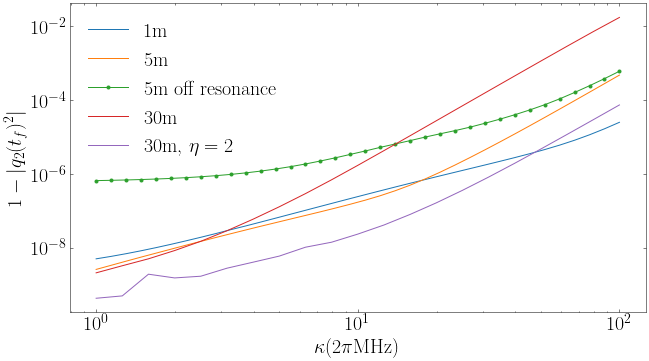

In [47]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(9,5), sharey = True, constrained_layout=True)

ax1.loglog(all_kappas/(2e-3*π), 1-P_transfer_1m_71modes[:,0], label = '1m')
ax1.loglog(all_kappas/(2e-3*π), 1-P_transfer_5m[:,0], label = '5m')
ax1.loglog(all_kappas/(2e-3*π), 1-P_transfer_5m_offresonance[:,0],'.-', label = '5m off resonance')
ax1.loglog( all_kappas_30/(2e-3*π), 1-P_transfer_30m[:,0], label = '30m')
ax1.loglog(all_kappas_30/(2e-3*π), 1-P_transfer_30m_quarter[:,0], label = '30m, $\\eta=2$')

# ax1.loglog(all_kappas_30/(2e-3*π), 1-P_transfer_30m_half[:,0], label = '30m, $\\eta=2$')




ax1.set_ylabel('$$1- |q_2(t_f)^2|$$')
ax1.set_xlabel(' $ \kappa (2\pi \\text{MHz}) $ ')

ax1.legend()

plt.show()

## Adjusting lamb para 30m $\kappa/4$

Heuristic calculation of Lamb shift

In [ ]:
P_lamb_30m_half = []
for i,j in enumerate(np.linspace(-0.0116-0.000019, -0.0116 -0.000021, 4)):
    P_lamb_30m_half.append([state_transfer(δ1=2*π*8.40701933547913, δ2=2*π*8.40701933547913,
                   ω1=2*π*8.40701933547913, ω2=2*π*8.40701933547913, lamb_shift=j*all_kappas[0], Tfp=15, kappa=all_kappas[0], quiet=True, σ=0.25)[0]])
    print(f'Fidelity = {1-np.array(P_lamb_30m_half[i])} for a Lambshift of {j}')

In [ ]:
P_lamb_5m_10MHz = []
for i,j in enumerate(np.linspace(-0.012187055555555552-0.0000001, -0.012187055555555552+0.0000001, 10)):
    P_lamb_5m_10MHz.append([state_transfer(δ1=2*π*8.416408398466828, δ2=2*π*8.416408398466828,
                   ω1=2*π*8.416408398466828, ω2=2*π*8.416408398466828, lamb_shift=j*all_kappas[5], kappa=all_kappas[5], Tfp=18, lwv=5, Nm=351, quiet=True)[0]])
    print(f'Fidelity = {1-np.array(P_lamb_5m_1MHz[i])} for a Lambshift of {j}')

## Adjusting Lamb for 1m waveguide

In [203]:
P_lamb_5m_1MHz = []
for i,j in enumerate(np.linspace(-0.01735-0.000, -0.01735+0.0001, 10)):
    P_lamb_5m_1MHz.append([state_transfer(δ1=2*π*8.492099722936853, δ2=2*π*8.492099722936853,
                   ω1=2*π*8.492099722936853, ω2=2*π*8.492099722936853, lamb_shift=j*all_kappas[18], kappa=all_kappas[18], Tfp=20, lwv=1, Nm=71, quiet=True)[0]])
    print(f'Fidelity = {1-np.array(P_lamb_5m_1MHz[i])} for a Lambshift of {j}')

Initial value of the control g_1(-tf)= (2π)*1.3005000161795633e-07MHz
κ1= (2π) 63.09573444801933 MHz
|q_1(tf)|^2 = 2.3086116478445143e-07
|c_1(tf)|^2 = 1.24971894341366e-06
|wv(tf)|^2  = 3.5610860482478616e-06 (max = 0.47710123569808666)
|c_2(tf)|^2 = 2.1426881912733213e-06
|q_2(tf)|^2 = 0.9999928156454848
Fidelity = [7.18435452e-06] for a Lambshift of -0.01735
Initial value of the control g_1(-tf)= (2π)*1.3005000161795633e-07MHz
κ1= (2π) 63.09573444801933 MHz
|q_1(tf)|^2 = 2.2999818537849424e-07
|c_1(tf)|^2 = 1.2521549942357312e-06
|wv(tf)|^2  = 3.5632359152706545e-06 (max = 0.47710115071720055)
|c_2(tf)|^2 = 2.1375421967245414e-06
|q_2(tf)|^2 = 0.9999928170686635
Fidelity = [7.18293134e-06] for a Lambshift of -0.01733888888888889
Initial value of the control g_1(-tf)= (2π)*1.3005000161795633e-07MHz
κ1= (2π) 63.09573444801933 MHz
|q_1(tf)|^2 = 2.2971178843341954e-07
|c_1(tf)|^2 = 1.2546129041712362e-06
|wv(tf)|^2  = 3.565476408235373e-06 (max = 0.4771010657044915)
|c_2(tf)|^2 = 2.1324

In [102]:
control = setup.Exp2QB2Cavities(δLamb = -0.012189*all_kappas[0], δ1=2*π*8.416408398466828, δ2=2*π*8.416408398466828,
                   ω1=2*π*8.416408398466828, ω2=2*π*8.416408398466828, g1=0, g2=0, κ1=all_kappas[0], κ2=all_kappas[0], l=1, mmax=80)
np.argmin(np.abs(control.ωrelevant-control.ω1))
control.ωrelevant[36]/2/π 

8.492099722936853